In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import matplotlib.pyplot as plt 

In [1]:

import sys
sys.path.append('../')
import pandas as pd 
import numpy as np 
from src.utils.io.read import RawDataReader
from src.settings import Settings
from src.utils.dates import get_nyse_business_dates

In [2]:
from src.preprocessing.index_roll_dates import get_index_roll_dates 

In [3]:
rdr = RawDataReader(raw_data_directory=Settings.backfill.paths.RAW_DATA_PATH)

In [4]:
prices_db = rdr.read_prices()

In [5]:
wti_prices_db = prices_db[prices_db['Name']=='CL']

In [6]:
wti_prices_db['tradeDate'] = pd.to_datetime(wti_prices_db['tradeDate']).dt.date

In [7]:
business_dates = get_nyse_business_dates(wti_prices_db['tradeDate'].min(),
                        wti_prices_db['tradeDate'].max())
                        

In [8]:
wti_prices_db  =wti_prices_db[wti_prices_db['tradeDate'].isin(business_dates)]

In [9]:
wti_prices_db.columns.tolist() 

['Unnamed: 0',
 'tradeDate',
 'Name',
 'F1_Price',
 'F2_Price',
 'F3_Price',
 'F1_RolledPrice',
 'F2_RolledPrice',
 'F3_RolledPrice']

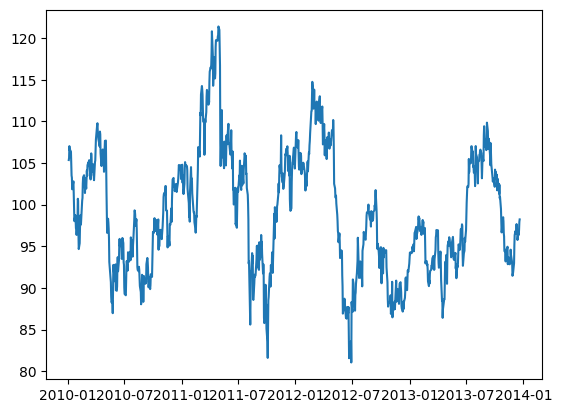

In [13]:
plt.plot(wti_prices_db.head(1000)['tradeDate'], wti_prices_db.head(1000)['F1_RolledPrice'], '-')

In [ ]:
index_roll_dates_df = get_index_roll_dates(start_date = wti_prices_db['tradeDate'].min(),
                    end_date = wti_prices_db['tradeDate'].max(),
                    roll_start_day  = 5,
                    roll_end_day  = 9,
                    business_days =business_dates) 

In [ ]:
index_roll_dates_df.isna().sum()

In [ ]:
index_roll_dates_df.tail(5)

# Days to next roll start 
if tradeDate <= current_roll_start_date: 
    days_to_next_roll_start =current_roll_start_date- tradeDate
elif tradeDate between current_roll_start_date and  current_roll_end_date
    days_to_next_roll_start = 0
elif tradeDate > current_roll_end_date: 
    days_to_next_roll_start = next_roll_start_date - tradeDate
    
# Days since last roll end 
if tradeDate >= current_roll_end_date: 
    days_since_last_roll_end =  tradeDate - current_roll_end_date
elif tradeDate between current_roll_start_date and  current_roll_end_date
    days_since_last_roll_end = 0
elif tradeDate < current_roll_start_date: 
    days_since_last_roll_end = tradeDate - previous_roll_end_date
    

In [ ]:
class PricePanel():
    
    def __init__(self, 
                 lookback_windows:int = list(range(1,20)), 
                 lookforward_windows: int = list(range(1,20)))->None:
        self.lookback_windows = lookback_windows
        self.lookforward_windows = lookforward_windows 
        self.panel = None
    def compute_backward_features(self, dataset:pd.DataFrame)->pd.DataFrame:
        dataset['F1MinusF2_RolledPrice'] = dataset['F1_RolledPrice'] - dataset['F2_RolledPrice'] 
        for name in [ 'F1_RolledPrice',
                     'F2_RolledPrice',
                     'F3_RolledPrice']:
            for w in  self.lookback_windows:
                dataset[f'prior_{w}D_{name}_change'] = dataset[f'{name}']-dataset[f'{name}'].shift(w)
        return dataset 
    def compute_forward_features(self, dataset:pd.DataFrame)->pd.DataFrame:
        for name in [ 'F1_RolledPrice',
                     'F2_RolledPrice',
                     'F3_RolledPrice']:
            for w in  self.lookforward_windows :
                dataset[f'forward_{w}D_{name}_change'] =dataset[f'{name}'].shift(-w) -  dataset[f'{name}']
        return dataset 
    def fit(self, dataset:pd.DataFrame)->None:
        dataset['month'] = [d.strftime('%Y-%m') for d in dataset['tradeDate']  ]
        dataset['F1MinusF2_RolledPrice'] = dataset['F1_RolledPrice'] - dataset['F2_RolledPrice'] 
        dataset = self.compute_backward_features(dataset)
        dataset = self.compute_forward_features(dataset)
        self.panel = dataset 
        

        
        

In [ ]:
price_panel_builder = PricePanel()

In [ ]:
price_panel_builder.fit(dataset= wti_prices_db)

In [ ]:
price_panel_builder.panel.columns.tolist()

In [ ]:
dataset = pd.merge(price_panel_builder.panel,
                   index_roll_dates_df,
                   on = 'month',
                   how ='left')

In [ ]:
index_roll_dates_df.tail(3)

In [ ]:
dataset

In [ ]:
def add_roll_recency_information(dataset):
    """
    Add days_to_next_roll_start and days_since_last_roll_end columns to dataset.
    
    Assumes dataset has columns:
    - tradeDate (or similar date column)
    - current_roll_start_date
    - current_roll_end_date
    - previous_roll_end_date
    - next_roll_start_date
    
    Parameters:
    -----------
    dataset : pd.DataFrame
        DataFrame with roll date columns and a tradeDate column
        
    Returns:
    --------
    pd.DataFrame : Dataset with added columns:
        - days_to_next_roll_start
        - days_since_last_roll_end
    """
    
    # Make a copy to avoid modifying original
    df = dataset.copy()
    
    # Ensure date columns are datetime
    date_columns = ['tradeDate', 'current_roll_start_date', 'current_roll_end_date', 
                   'previous_roll_end_date', 'next_roll_start_date']
    
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    
    # Days to next roll start logic
    df['days_to_next_roll_start'] = np.where(
        df['tradeDate'] <= df['current_roll_start_date'],
        # Case 1: Before current roll starts
        (df['current_roll_start_date'] - df['tradeDate']).dt.days,
        np.where(
            (df['tradeDate'] >= df['current_roll_start_date']) & 
            (df['tradeDate'] <= df['current_roll_end_date']),
            # Case 2: During current roll period
            0,
            # Case 3: After current roll ends
            (df['next_roll_start_date'] - df['tradeDate']).dt.days
        )
    )
    
    # Days since last roll end logic
    df['days_since_last_roll_end'] = np.where(
        df['tradeDate'] >= df['current_roll_end_date'],
        # Case 1: After current roll ends
        (df['tradeDate'] - df['current_roll_end_date']).dt.days,
        np.where(
            (df['tradeDate'] >= df['current_roll_start_date']) & 
            (df['tradeDate'] <= df['current_roll_end_date']),
            # Case 2: During current roll period
            0,
            # Case 3: Before current roll starts
            (df['tradeDate'] - df['previous_roll_end_date']).dt.days
        )
    )
    
    return df


In [ ]:
dataset=add_roll_recency_information(dataset)

In [ ]:
for name in [ 'current_roll_start_date',
             'current_roll_end_date',
             'previous_roll_start_date',
             'previous_roll_end_date',
             'next_roll_start_date',
             'next_roll_end_date']:
    print(name)
    dataset['tradeDate'] = pd.to_datetime(dataset['tradeDate']).dt.date
    dataset[name] = pd.to_datetime(dataset[name]).dt.date
    
    
    print(dataset['tradeDate'].dtype)
    print(dataset[name].dtype)
    
    tmp_dates = dataset[name].unique().tolist()
    
    df =  dataset[['tradeDate' ,  
                   'F1_RolledPrice',
                    'F2_RolledPrice',
                    'F3_RolledPrice',
                    'F1MinusF2_RolledPrice' ]].copy(deep=True)
    df = df[df['tradeDate'].isin(tmp_dates)].drop_duplicates(subset = 'tradeDate').rename(columns = {'tradeDate': name, 
                                                                 'F1_RolledPrice':  f'{name}_F1_RolledPrice',   
                                                                 'F2_RolledPrice':  f'{name}_F2_RolledPrice' ,
                                                                  'F3_RolledPrice':  f'{name}_F3_RolledPrice' , 
                                                                  'F1MinusF2_RolledPrice' : f'{name}_F1MinusF2_RolledPrice'  
                                                                 }   
                                                                )
    dataset = pd.merge(dataset,
                       df,
                       on = name, 
                       how ='left')
    



In [ ]:
dataset.columns.tolist()

In [ ]:
dataset[[ 'current_roll_start_date_F1_RolledPrice',
 'current_roll_start_date_F2_RolledPrice',
 'current_roll_start_date_F3_RolledPrice',
 'current_roll_start_date_F1MinusF2_RolledPrice',
 'current_roll_end_date_F1_RolledPrice',
 'current_roll_end_date_F2_RolledPrice',
 'current_roll_end_date_F3_RolledPrice',
 'current_roll_end_date_F1MinusF2_RolledPrice',
 'previous_roll_start_date_F1_RolledPrice',
 'previous_roll_start_date_F2_RolledPrice',
 'previous_roll_start_date_F3_RolledPrice',
 'previous_roll_start_date_F1MinusF2_RolledPrice',
 'previous_roll_end_date_F1_RolledPrice',
 'previous_roll_end_date_F2_RolledPrice',
 'previous_roll_end_date_F3_RolledPrice',
 'previous_roll_end_date_F1MinusF2_RolledPrice',
 'next_roll_start_date_F1_RolledPrice',
 'next_roll_start_date_F2_RolledPrice',
 'next_roll_start_date_F3_RolledPrice',
 'next_roll_start_date_F1MinusF2_RolledPrice',
 'next_roll_end_date_F1_RolledPrice',
 'next_roll_end_date_F2_RolledPrice',
 'next_roll_end_date_F3_RolledPrice',
 'next_roll_end_date_F1MinusF2_RolledPrice']].isna().sum()
 

In [ ]:
dataset.shape